In [21]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [22]:
data_dir = "D:/ViolenceDetection/Dataset"  

In [23]:
#Prepare dataset
data = []
for class_name in ['violence', 'non_violence']:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        data.append([os.path.join(class_dir, img_name), class_name])

data_df = pd.DataFrame(data, columns=['image_path', 'class_name'])
train_df, valid_df = train_test_split(data_df, test_size=0.25, stratify=data_df['class_name'], random_state=42)

In [24]:
# Data generators
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.25
)

train_gen = datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='class_name',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

valid_gen = datagen.flow_from_dataframe(
    valid_df,
    x_col='image_path',
    y_col='class_name',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 14700 validated image filenames belonging to 2 classes.
Found 4900 validated image filenames belonging to 2 classes.


In [25]:
from tensorflow.keras import layers, models

def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model

model = create_model()

def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)  # Convert predictions to binary (0 or 1)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float'), axis=0)
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return tf.reduce_mean(f1)  # Return the mean F1 score across all batches

# Compile the model with the custom metric
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision',f1_score])


#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['precision'])
model.summary()


c:\Users\SUJAL\.conda\envs\team113\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,263,809 (73.49 MB)

 Trainable params: 19,263,809 (73.49 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history = model.fit(
    train_gen,
    epochs=5,
    validation_data=valid_gen       
)

Epoch 1/5
460/460 ━━━━━━━━━━━━━━━━━━━━ 436s 949ms/step - accuracy: 0.7125 - f1_score: 0.2895 - loss: 0.5591 - precision: 0.7584 - val_accuracy: 0.7039 - val_f1_score: 0.1931 - val_loss: 0.5478 - val_precision: 0.9310
Epoch 2/5
460/460 ━━━━━━━━━━━━━━━━━━━━ 374s 812ms/step - accuracy: 0.7940 - f1_score: 0.2997 - loss: 0.4450 - precision: 0.8392 - val_accuracy: 0.7816 - val_f1_score: 0.3842 - val_loss: 0.4456 - val_precision: 0.7283
Epoch 3/5
460/460 ━━━━━━━━━━━━━━━━━━━━ 386s 839ms/step - accuracy: 0.8446 - f1_score: 0.3244 - loss: 0.3539 - precision: 0.8641 - val_accuracy: 0.8608 - val_f1_score: 0.3519 - val_loss: 0.3194 - val_precision: 0.8356
Epoch 4/5
460/460 ━━━━━━━━━━━━━━━━━━━━ 381s 828ms/step - accuracy: 0.8532 - f1_score: 0.3225 - loss: 0.3277 - precision: 0.8743 - val_accuracy: 0.8745 - val_f1_score: 0.3324 - val_loss: 0.2788 - val_precision: 0.8799
Epoch 5/5
460/460 ━━━━━━━━━━━━━━━━━━━━ 378s 821ms/step - accuracy: 0.8817 - f1_score: 0.3323 - loss: 0.2776 - precision: 0.8934 - va

In [ ]:
# Evaluate on validation data
val_loss, val_acc = model.evaluate(valid_gen)
print(f"Validation Accuracy: {val_acc:.4f}")

In [28]:
from datetime import datetime
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_filename = f"model_{timestamp}.weights.h5"
print(model_filename)
model.save_weights(model_filename)

model_2024-11-26_15-36-40.weights.h5


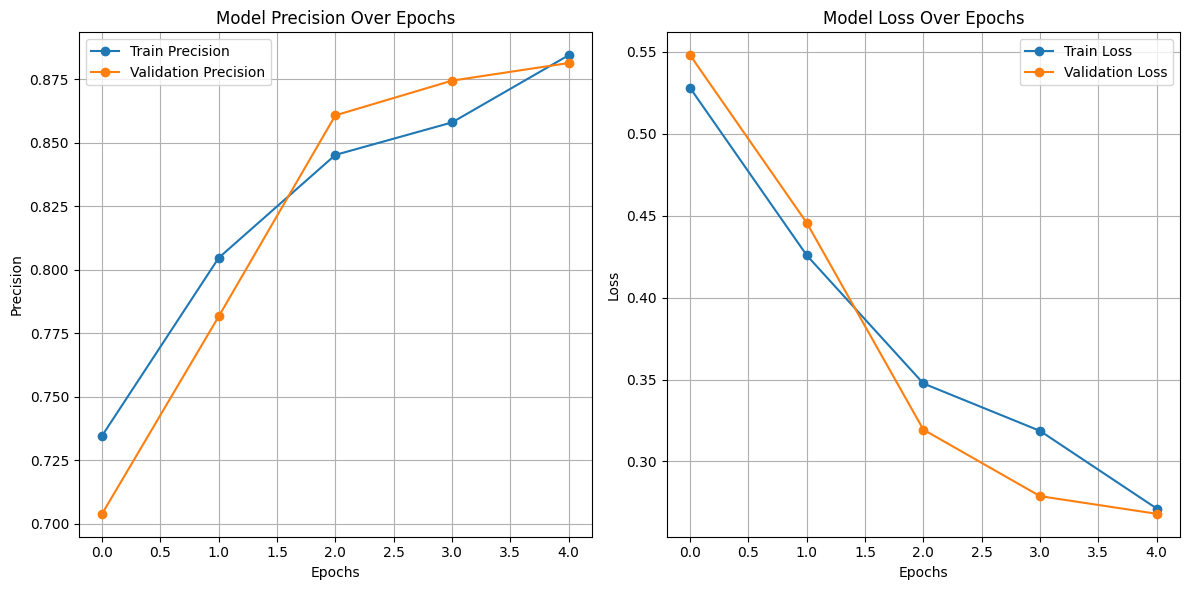

In [29]:
import matplotlib.pyplot as plt

# Extract precision values from history
train_precision = history.history['accuracy']
val_precision = history.history['val_accuracy']

# Extract loss values from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot precision over epochs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_precision, label='Train Precision', marker='o')
plt.plot(val_precision, label='Validation Precision', marker='o')
plt.title('Model Precision Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# Plot loss over epochs
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


In [30]:
import matplotlib.pyplot as plt
import cv2

def get_gradcam_heatmap(model, image, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.get_layer('dense_1').output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        predicted_class = tf.argmax(predictions[0])

        grads = tape.gradient(predictions[:, predicted_class], conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def plot_gradcam(image, heatmap):
    # Normalize the input image to the range [0, 255] for visualization
    image = (image * 255).astype('uint8')
    
    # Resize heatmap to match the input image size
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    
    # Apply color map to heatmap
    heatmap = np.uint8(255 * heatmap)  # Scale to [0, 255]
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Convert grayscale input image to RGB if needed
    if len(image.shape) == 2 or image.shape[2] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    # Blend the heatmap and the image
    overlay = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)
    
    # Plot the result
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()


In [31]:
import requests
from PIL import Image
from io import BytesIO
from tensorflow.keras.preprocessing.image import img_to_array


def process_video(video_path, model, last_conv_layer_name):
    # Load the video
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_indices = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_indices.append(cap.get(cv2.CAP_PROP_POS_FRAMES))
        # Resize and preprocess frame for model
        frame_resized = cv2.resize(frame, (224, 224))
        frame_array = img_to_array(frame_resized) / 255.0
        frames.append(frame_array)
    cap.release()

    # Convert frames to a batch
    frames = np.array(frames)
    predictions = model.predict(frames, batch_size=32)

    # Find the most confident violent frame
    violent_indices = np.where(predictions > 0.5)[0]
    if len(violent_indices) == 0:
        print("No violent frames detected.")
        return

    best_frame_idx = violent_indices[np.argmax(predictions[violent_indices])]
    best_frame = frames[best_frame_idx]

    # Generate Grad-CAM for the best frame
    heatmap = get_gradcam_heatmap(model, np.expand_dims(best_frame, axis=0), last_conv_layer_name)
    plot_gradcam(best_frame, heatmap)

    # Optionally save the heatmap
    cv2.imwrite("heatmap_output.jpg", best_frame * 255)
    print(f"Grad-CAM heatmap generated for frame {frame_indices[best_frame_idx]}.")

    # Convert the best frame and heatmap to PIL images for Telegram
    best_frame_pil = Image.fromarray((best_frame * 255).astype('uint8'))
    heatmap_pil = Image.fromarray((heatmap * 255).astype('uint8'))

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step


c:\Users\SUJAL\.conda\envs\team113\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: [['keras_tensor']]. Received: the structure of inputs=*
  warnings.warn(


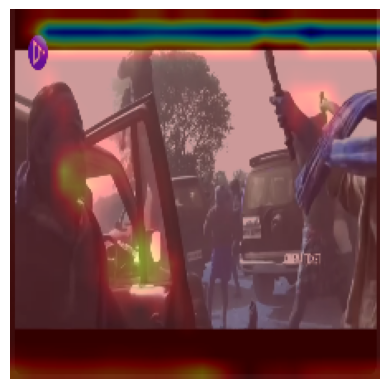

Grad-CAM heatmap generated for frame 325.0.


In [32]:
# Example usage
VIDEO_PATH = "asvr.mp4"

process_video(VIDEO_PATH, model, last_conv_layer_name='conv2d_3')


In [63]:
from onvif.client import ONVIFCamera
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
from PIL import Image
import requests
from io import BytesIO

# Connect to ONVIF camera
def connect_onvif_camera(ip, port, username, password):
    camera = ONVIFCamera(ip, port, username, password)
    media_service = camera.create_media_service()
    profiles = media_service.GetProfiles()
    stream_url = media_service.GetStreamUri({'StreamSetup': {'Stream': 'RTP-Unicast', 'Transport': 'RTSP'}, 
                                             'ProfileToken': profiles[0].token})
    return stream_url.Uri

In [87]:
import cv2
import numpy as np
import requests
from tensorflow.keras.utils import img_to_array

# Replace with your bot's token and chat ID
TELEGRAM_BOT_TOKEN = "7779836665:AAFJ8HuswsR9tWSVkmXkQjCkE1u4tyEuodk"
TELEGRAM_CHAT_ID = "-4583289496"

# Function to send an image to Telegram
def send_image_to_telegram(image_path, caption):
    url = f"https://api.telegram.org/bot{TELEGRAM_BOT_TOKEN}/sendPhoto"
    with open(image_path, "rb") as img:
        files = {"photo": img}
        data = {"chat_id": TELEGRAM_CHAT_ID, "caption": caption}
        response = requests.post(url, files=files, data=data)
        if response.status_code == 200:
            print("Image sent to Telegram successfully.")
        else:
            print("Failed to send image to Telegram:", response.text)


In [88]:
def process_live_stream(stream_url, model, last_conv_layer_name):
    cap = cv2.VideoCapture(stream_url)
    
    if not cap.isOpened():
        print("Error: Unable to open CCTV stream.")
        return
    
    # Define and position the CCTV feed window
    cv2.namedWindow("CCTV Feed", cv2.WINDOW_NORMAL)
    cv2.moveWindow("CCTV Feed", 1000, 10)
    cv2.resizeWindow("CCTV Feed", 500, 500)
    
    frame_count = 0
    violent_count = 0
    best_frame = None
    best_heatmap = None
    retry_count = 0
    max_retries = 5

    while True:
        ret, frame = cap.read()
        if not ret:
            retry_count += 1
            if retry_count > max_retries:
                print("Error: Unable to retrieve frames. Exiting.")
                break
            continue  # Retry reading frames
        retry_count = 0  # Reset retries on successful read

        frame_count += 1
        if frame_count % 60 != 0:  # Process every 60th frame
            continue

        # Resize and preprocess frame
        frame_resized = cv2.resize(frame, (224, 224))
        frame_array = img_to_array(frame_resized) / 255.0
        frame_array = np.expand_dims(frame_array, axis=0)

        # Predict using the model
        prediction = model.predict(frame_array)[0][0]
        activity = "Violent" if prediction > 0.5 else "Non-Violent"
        print(f"Frame {frame_count}: Detected activity - {activity}")

        if activity == "Violent":
            violent_count += 1
            heatmap = get_gradcam_heatmap(model, frame_array, last_conv_layer_name)
            if best_frame is None or prediction > 0.5:
                best_frame = frame
                best_heatmap = heatmap

        else:
            violent_count = 0

        if violent_count >= 5:
            print("WARNING: Continuous violent activity detected!")
            if best_frame is not None and best_heatmap is not None:
                best_frame_path = "best_frame.jpg"
                best_heatmap_path = "best_heatmap.jpg"
                cv2.imwrite(best_frame_path, best_frame)
                cv2.imwrite(best_heatmap_path, best_heatmap)
                send_image_to_telegram(best_frame_path, "Best frame detected as violent")
                send_image_to_telegram(best_heatmap_path, "Corresponding Grad-CAM heatmap")
                os.remove(best_frame_path)
                os.remove(best_heatmap_path)

        # Display the frame
        cv2.imshow("CCTV Feed", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to exit
            break

    cap.release()
    cv2.destroyAllWindows()


In [98]:
# Example usage
ip = "192.168.1.8"  # Replace with CCTV IP
port = 8899
username = "47865558"  # Replace with your credentials
password = "Sujal04648*"
try:
    #model.load_weights("model_2024-11-26_14-28-10.weights.h5")
    stream_url = connect_onvif_camera(ip, port, username, password)
    process_live_stream(stream_url, model, last_conv_layer_name='conv2d_3')
except Exception as e:
    print(f"Error: {e}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Frame 60: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Frame 120: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Frame 180: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Frame 240: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Frame 300: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Frame 360: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Frame 420: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Frame 480: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Frame 540: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Frame 600: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Frame 660: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Frame 720: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4

In [99]:
import cv2
import numpy as np
import requests
from tensorflow.keras.utils import img_to_array

# Function to process webcam feed
def process_webcam(model, last_conv_layer_name):
    cap = cv2.VideoCapture(0)  # 0 is the default webcam ID
    
    if not cap.isOpened():
        print("Error: Unable to access the webcam.")
        return
    
    frame_count = 0
    violent_count = 0  # Counter for consecutive violent frames
    violent_frames = []  # Store frames classified as violent

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        if frame_count % 60 != 0:  # Process every 50th frame (reduce processing load)
            continue

        # Resize and preprocess frame for the model
        frame_resized = cv2.resize(frame, (224, 224))
        frame_array = img_to_array(frame_resized) / 255.0
        frame_array = np.expand_dims(frame_array, axis=0)

        # Predict using the model
        prediction = model.predict(frame_array)[0][0]
        activity = "Violent" if prediction < 0.8 else "Non-Violent"
        print(f"Frame {frame_count}: Detected activity - {activity}")

        if activity == "Violent":
            violent_count += 1
            violent_frames.append(frame)  # Save original frame
            
            # Generate Grad-CAM heatmap
            heatmap = get_gradcam_heatmap(model, frame_array, last_conv_layer_name)
            plot_gradcam(frame_resized, heatmap)

            # Save the heatmap
            heatmap_path = f"heatmap_frame_{frame_count}.jpg"
            cv2.imwrite(heatmap_path, heatmap)

        else:
            violent_count = 0  # Reset if non-violent
            violent_frames.clear()  # Clear stored frames

        # Check for 5 consecutive "Violent" frames
        if violent_count >= 5:
            print("WARNING: Continuous violent activity detected!")

            # Save and send top 5 frames with their heatmaps to Telegram
            for i, violent_frame in enumerate(violent_frames[:5]):
                frame_path = f"violent_frame_{i + 1}.jpg"
                cv2.imwrite(frame_path, violent_frame)
                send_image_to_telegram(frame_path, f"Original frame {i + 1}")

                # Send the corresponding Grad-CAM heatmap
                gradcam_path = f"gradcam_frame_{i + 1}.jpg"
                cv2.imwrite(gradcam_path, heatmap)
                send_image_to_telegram(gradcam_path, f"Grad-CAM for frame {i + 1}")

            violent_frames.clear()  # Reset frames after sending

        # Display the frame
        cv2.imshow("Webcam Feed", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to exit
            break

    cap.release()
    cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Frame 60: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Frame 120: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Frame 180: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Frame 240: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Frame 300: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Frame 360: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Frame 420: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Frame 480: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Frame 540: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Frame 600: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Frame 660: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Frame 720: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4

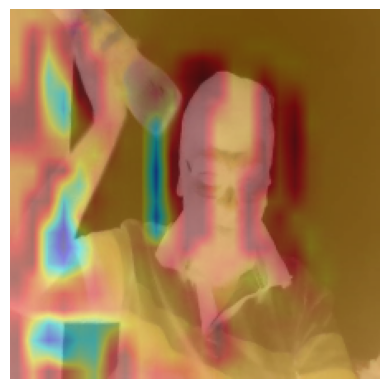

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Frame 1260: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Frame 1320: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Frame 1380: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Frame 1440: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Frame 1500: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Frame 1560: Detected activity - Violent


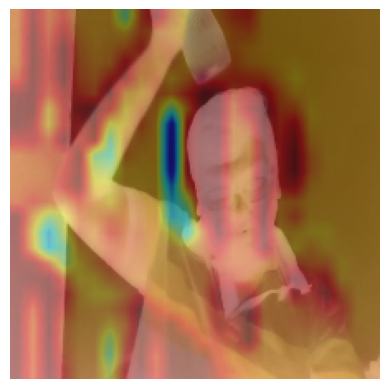

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Frame 1620: Detected activity - Violent


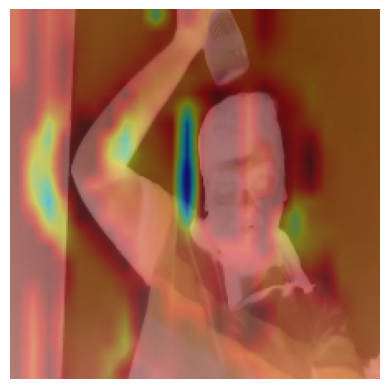

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Frame 1680: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Frame 1740: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Frame 1800: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Frame 1860: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Frame 1920: Detected activity - Violent


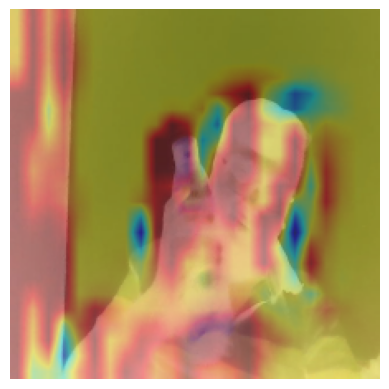

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Frame 1980: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Frame 2040: Detected activity - Violent


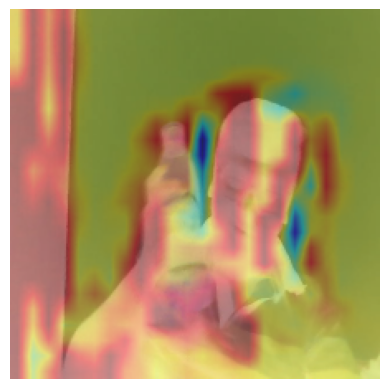

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Frame 2100: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Frame 2160: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Frame 2220: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Frame 2280: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Frame 2340: Detected activity - Non-Violent


In [102]:
#model.load_weights("model_2024-11-26_12-54-27.weights.h5")
process_webcam(model, last_conv_layer_name='conv2d_3') 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Frame 60: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Frame 120: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Frame 180: Detected activity - Violent


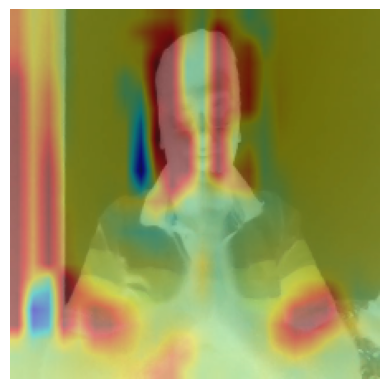

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Frame 240: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Frame 300: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Frame 360: Detected activity - Violent


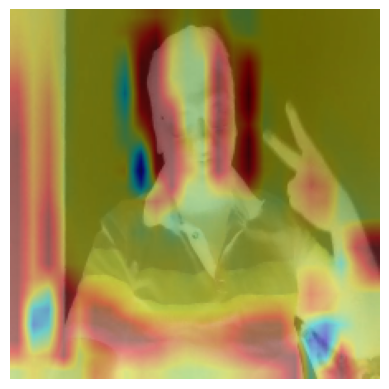

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Frame 420: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Frame 480: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Frame 540: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Frame 600: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Frame 660: Detected activity - Violent


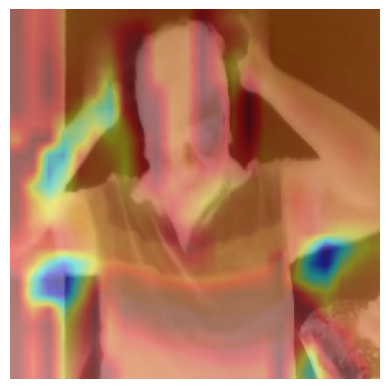

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Frame 720: Detected activity - Violent


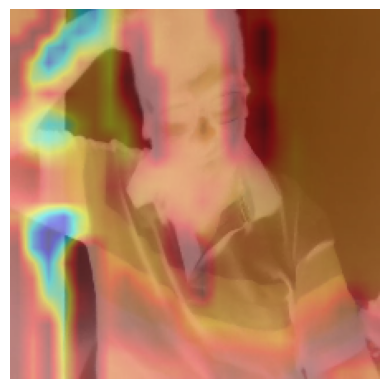

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Frame 780: Detected activity - Violent


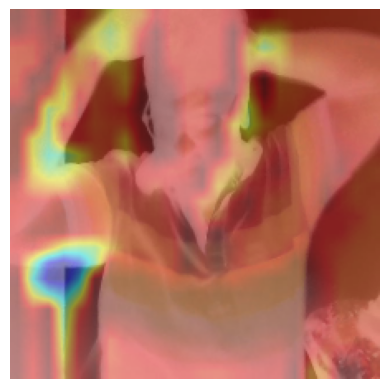

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Frame 840: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Frame 900: Detected activity - Violent


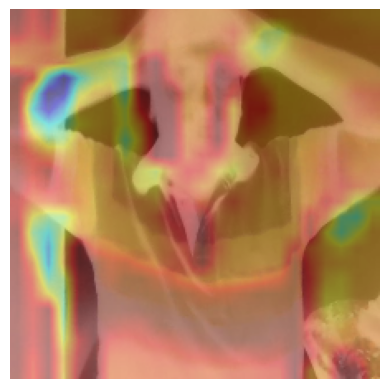

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Frame 960: Detected activity - Violent


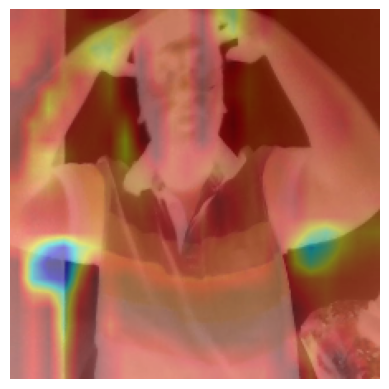

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Frame 1020: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Frame 1080: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Frame 1140: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Frame 1200: Detected activity - Violent


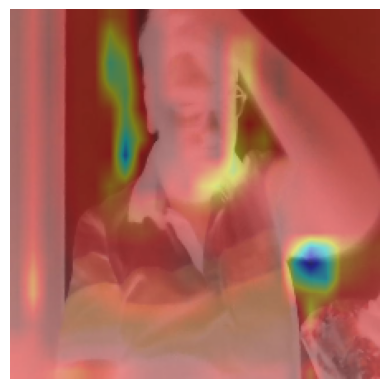

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Frame 1260: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Frame 1320: Detected activity - Violent


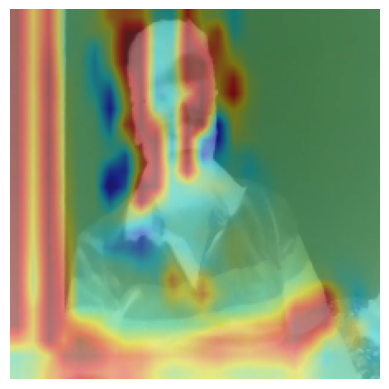

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Frame 1380: Detected activity - Violent


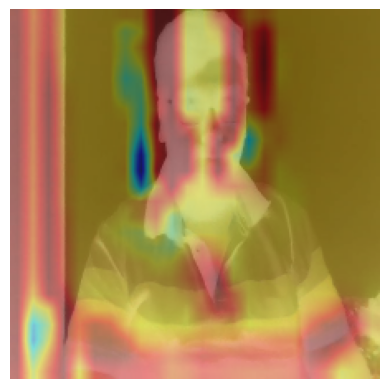

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Frame 1440: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Frame 1500: Detected activity - Violent


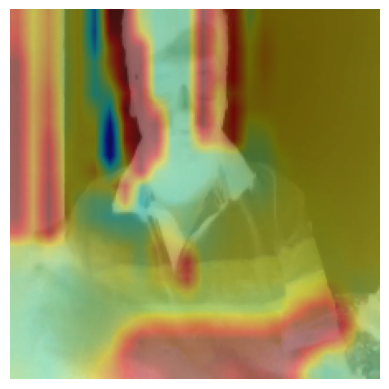

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Frame 1560: Detected activity - Violent


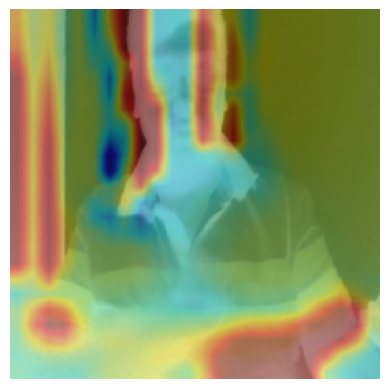

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Frame 1620: Detected activity - Violent


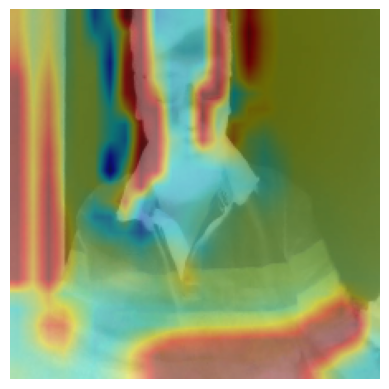

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Frame 1680: Detected activity - Violent


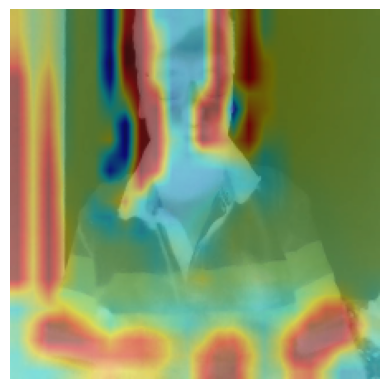

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Frame 1740: Detected activity - Violent


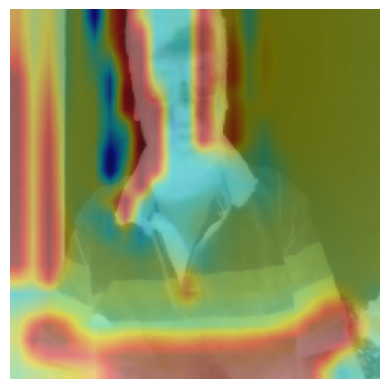

Image sent to Telegram successfully.
Image sent to Telegram successfully.
Image sent to Telegram successfully.
Image sent to Telegram successfully.
Image sent to Telegram successfully.
Image sent to Telegram successfully.
Image sent to Telegram successfully.
Image sent to Telegram successfully.
Image sent to Telegram successfully.
Image sent to Telegram successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Frame 1800: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Frame 1860: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Frame 1920: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Frame 1980: Detected activity - Non-Violent


In [104]:
process_webcam(model, last_conv_layer_name='conv2d_3') 

In [117]:
import cv2
import numpy as np
import requests
from tensorflow.keras.utils import img_to_array

# Function to process webcam feed
def process_webcam2(model, last_conv_layer_name):
    cap = cv2.VideoCapture(0)  # 0 is the default webcam ID
    
    if not cap.isOpened():
        print("Error: Unable to access the webcam.")
        return
    
    frame_count = 0
    violent_count = 0  # Counter for consecutive violent frames
    violent_frames = []  # Store frames classified as violent

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        if frame_count % 20 != 0:  
            continue

        # Resize and preprocess frame for the model
        frame_resized = cv2.resize(frame, (224, 224))
        frame_array = img_to_array(frame_resized) / 255.0
        frame_array = np.expand_dims(frame_array, axis=0)

        # Predict using the model
        prediction = model.predict(frame_array)[0][0]
        activity = "Violent" if prediction < 0.7 else "Non-Violent"
        print(f"Frame {frame_count}: Detected activity - {activity}")

        if activity == "Violent":
            violent_count += 1
            violent_frames.append(frame)  # Save original frame
            
            # Generate Grad-CAM heatmap
            heatmap = get_gradcam_heatmap(model, frame_array, last_conv_layer_name)
            plot_gradcam(frame_resized, heatmap)

            # Save the heatmap
            heatmap_path = f"heatmap_frame_{frame_count}.jpg"
            cv2.imwrite(heatmap_path, heatmap)

        else:
            violent_count = 0  # Reset if non-violent
            violent_frames.clear()  # Clear stored frames

        # Check for 3 consecutive "Violent" frames
        if violent_count >= 3:
            print("WARNING: Continuous violent activity detected!")

            # Save and send top 5 frames with their heatmaps to Telegram
            for i, violent_frame in enumerate(violent_frames[:3]):
                frame_path = f"violent_frame_{i + 1}.jpg"
                cv2.imwrite(frame_path, violent_frame)
                send_image_to_telegram(frame_path, f"Original frame {i + 1}")

                # Send the corresponding Grad-CAM heatmap
                gradcam_path = f"gradcam_frame_{i + 1}.jpg"
                cv2.imwrite(gradcam_path, heatmap)
                send_image_to_telegram(gradcam_path, f"Grad-CAM for frame {i + 1}")

            violent_frames.clear()  # Reset frames after sending

        # Display the frame
        cv2.imshow("Webcam Feed", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to exit
            break

    cap.release()
    cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Frame 20: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Frame 40: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Frame 60: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Frame 80: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Frame 100: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Frame 120: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Frame 140: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Frame 160: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Frame 180: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Frame 200: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Frame 220: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Frame 240: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms

c:\Users\SUJAL\.conda\envs\team113\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: [['keras_tensor']]. Received: the structure of inputs=*
  warnings.warn(


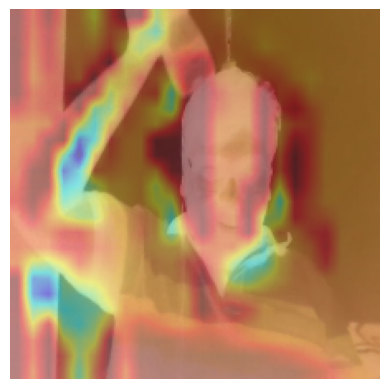

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Frame 560: Detected activity - Violent


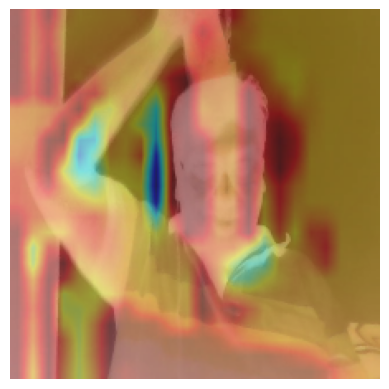

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Frame 580: Detected activity - Violent


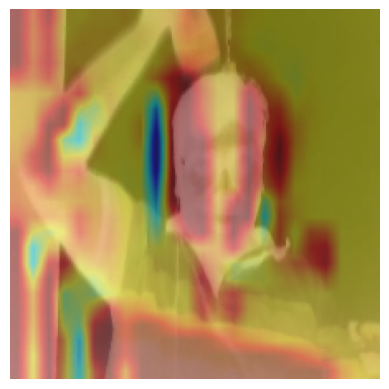

Image sent to Telegram successfully.
Image sent to Telegram successfully.
Image sent to Telegram successfully.
Image sent to Telegram successfully.
Image sent to Telegram successfully.
Image sent to Telegram successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Frame 600: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Frame 620: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Frame 640: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Frame 660: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Frame 680: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Frame 700: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Frame 720: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Frame 740: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Frame 760: Detected activity - Non-Violent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Frame 780: 

In [118]:
process_webcam2(model, last_conv_layer_name='conv2d_3') 